### Player Goals

This notebook trains and predict a model to predict how likely any given player is to score a goal in an NHL game. We fit XGBoost models, with Bayesian cross-validation to lessen the risk of over-fitting. Finally, we compare these predictions with historical betting odds from sportsbooks across the US.

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from credentials import HOCKEY_DB_NAME, HOCKEY_DB_PWD
from schedule import get_schedule
from datetime import date
from betting_utils import convert_prob_to_american
import seaborn as sns
import requests

import datetime as dt
from datetime import date, timedelta
from pytz import timezone

import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
def make_synthetic_roster(r):
    game_pk = r['game_pk']
    game_date = r['game_date']
    home_team = r['home_team']
    away_team = r['away_team']
    
    away_players = [x['roster']['roster'] for x in rosters['teams'] if x['name'] == away_team][0]
    away_players = pd.concat([make_synthetic_boxscore(x) for x in away_players])
    away_players['team'] = away_team
    away_players['opposing_team'] = home_team
    away_players['is_home_team'] = 0
    
    home_players = [x['roster']['roster'] for x in rosters['teams'] if x['name'] == home_team][0]
    home_players = pd.concat([make_synthetic_boxscore(x) for x in home_players])
    home_players['team'] = home_team
    home_players['opposing_team'] = away_team
    home_players['is_home_team'] = 1

    players = pd.concat([home_players, away_players])
    players['game_pk'] = game_pk
    players['game_date'] = game_date
    players['game_final'] = False
    
    return(players)
    
def make_synthetic_boxscore(b):
    person = b['person']
    position = b['position']
    is_goalie = position['name'] == "Goalie"
    
    return(pd.DataFrame({"player_id": person['id']
                         , "player_name": person['fullName']
                         , "position": position['name']
                         , "is_goalie": position['name'] == 'Goalie'
                         }, index = [1]))

In [3]:
s = get_schedule(startdate = date.today(), enddate = date.today())

rosters = requests.get('https://statsapi.web.nhl.com/api/v1/teams/', params={'expand': 'team.roster'}).json()

s['game_date'] = pd.to_datetime(s['game_date'])
s['game_date'] = s['game_date'].apply(lambda x: x.astimezone(timezone('US/Eastern')))
s['game_date'] = s['game_date'].apply(lambda x: x.tz_localize(None))
s

,game_pk,game_type,game_date,game_final,home_team,away_team,home_score,away_score
0,2022020301,R,2022-11-22 19:00:00,False,Montréal Canadiens,Buffalo Sabres,-1,-1
1,2022020302,R,2022-11-22 22:30:00,False,Los Angeles Kings,New York Rangers,-1,-1


In [4]:
synth_today = pd.concat([make_synthetic_roster(a) for i, a in s.iterrows()])
synth_today

,player_id,player_name,position,is_goalie,team,opposing_team,is_home_team,game_pk,game_date,game_final
1,8477494,Jonathan Drouin,Left Wing,False,Montréal Canadiens,Buffalo Sabres,1,2022020301,2022-11-22 19:00:00,False
1,8474149,Evgenii Dadonov,Right Wing,False,Montréal Canadiens,Buffalo Sabres,1,2022020301,2022-11-22 19:00:00,False
1,8474596,Jake Allen,Goalie,True,Montréal Canadiens,Buffalo Sabres,1,2022020301,2022-11-22 19:00:00,False
1,8474884,Mike Hoffman,Left Wing,False,Montréal Canadiens,Buffalo Sabres,1,2022020301,2022-11-22 19:00:00,False
1,8475227,Chris Wideman,Defenseman,False,Montréal Canadiens,Buffalo Sabres,1,2022020301,2022-11-22 19:00:00,False
...,...,...,...,...,...,...,...,...,...,...
1,8480833,Vitali Kravtsov,Right Wing,False,New York Rangers,Los Angeles Kings,0,2022020302,2022-11-22 22:30:00,False
1,8481554,Kaapo Kakko,Right Wing,False,New York Rangers,Los Angeles Kings,0,2022020302,2022-11-22 22:30:00,False
1,8481708,Zac Jones,Defenseman,False,New York Rangers,Los Angeles Kings,0,2022020302,2022-11-22 22:30:00,False
1,8482073,Braden Schneider,Defenseman,False,New York Rangers,Los Angeles Kings,0,2022020302,2022-11-22 22:30:00,False


### Get real data

In [5]:
engine = create_engine('postgresql://baseball:{}@localhost:5432/{}'.format(HOCKEY_DB_PWD, HOCKEY_DB_NAME))

In [6]:
dat = pd.read_sql("""SELECT b.*, s.game_date
, CASE WHEN b.team = s.home_team THEN 1 ELSE 0 END AS is_home_team
, True AS game_final
FROM nhl_player_boxscore b
     INNER JOIN nhl_schedule s ON b.game_pk = s.game_pk
     WHERE s.game_date >= '2019-06-01';""", engine)

In [7]:
dat.query('shot_attempts > shots')

,player_id,player_name,position,is_goalie,assists,goals,shots,shot_attempts,plus_minus,shots_against,...,short_handed_save_percentage,even_strength_save_percentage,team,opposing_team,opposing_goalie,game_pk,time_on_ice,game_date,is_home_team,game_final
4,8477949,Alex Tuch,Right Wing,False,0,0,2,3,-1,NaN,...,None,NaN,Vegas Golden Knights,St. Louis Blues,Jordan Binnington,2020020620,910,2021-04-07 21:00:00,0,True
6,8474565,Alex Pietrangelo,Defenseman,False,0,0,4,8,0,NaN,...,None,NaN,Vegas Golden Knights,St. Louis Blues,Jordan Binnington,2020020620,1860,2021-04-07 21:00:00,0,True
7,8477447,Shea Theodore,Defenseman,False,0,0,9,10,0,NaN,...,None,NaN,Vegas Golden Knights,St. Louis Blues,Jordan Binnington,2020020620,1842,2021-04-07 21:00:00,0,True
8,8477931,Tomas Nosek,Left Wing,False,0,0,2,3,-1,NaN,...,None,NaN,Vegas Golden Knights,St. Louis Blues,Jordan Binnington,2020020620,657,2021-04-07 21:00:00,0,True
11,8475188,Brayden McNabb,Defenseman,False,0,0,0,2,0,NaN,...,None,NaN,Vegas Golden Knights,St. Louis Blues,Jordan Binnington,2020020620,1067,2021-04-07 21:00:00,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135527,8474600,Roman Josi,Defenseman,False,1,1,8,10,0,NaN,...,None,NaN,Nashville Predators,Arizona Coyotes,Connor Ingram,2022020297,1807,2022-11-21 20:00:00,1,True
135529,8478851,Alexandre Carrier,Defenseman,False,0,0,2,3,-1,NaN,...,None,NaN,Nashville Predators,Arizona Coyotes,Connor Ingram,2022020297,1192,2022-11-21 20:00:00,1,True
135530,8474151,Ryan McDonagh,Defenseman,False,0,0,1,2,1,NaN,...,None,NaN,Nashville Predators,Arizona Coyotes,Connor Ingram,2022020297,749,2022-11-21 20:00:00,1,True
135531,8477446,Michael McCarron,Right Wing,False,0,0,1,2,0,NaN,...,None,NaN,Nashville Predators,Arizona Coyotes,Connor Ingram,2022020297,619,2022-11-21 20:00:00,1,True


In [8]:
dat = pd.concat([dat, synth_today]).reset_index()

In [9]:
dat = dat.sort_values(['game_date', 'game_pk', 'player_id'])

In [10]:
dat.head()

,index,player_id,player_name,position,is_goalie,assists,goals,shots,shot_attempts,plus_minus,...,short_handed_save_percentage,even_strength_save_percentage,team,opposing_team,opposing_goalie,game_pk,time_on_ice,game_date,is_home_team,game_final
101939,101939,8467950,Craig Anderson,Goalie,True,0.0,0.0,0.0,0.0,0.0,...,None,87.5,Ottawa Senators,Toronto Maple Leafs,Frederik Andersen,2019020001,3507.0,2019-10-02 19:00:00,0,True
101944,101944,8468493,Ron Hainsey,Defenseman,False,0.0,0.0,0.0,2.0,0.0,...,None,NaN,Ottawa Senators,Toronto Maple Leafs,Frederik Andersen,2019020001,1053.0,2019-10-02 19:00:00,0,True
101946,101946,8471676,Bobby Ryan,Right Wing,False,0.0,1.0,3.0,3.0,1.0,...,None,NaN,Ottawa Senators,Toronto Maple Leafs,Frederik Andersen,2019020001,916.0,2019-10-02 19:00:00,0,True
101956,101956,8473573,Artem Anisimov,Center,False,0.0,0.0,1.0,3.0,-4.0,...,None,NaN,Ottawa Senators,Toronto Maple Leafs,Frederik Andersen,2019020001,1180.0,2019-10-02 19:00:00,0,True
101968,101968,8474162,Jake Muzzin,Defenseman,False,0.0,0.0,1.0,2.0,0.0,...,None,NaN,Toronto Maple Leafs,Ottawa Senators,Craig Anderson,2019020001,1326.0,2019-10-02 19:00:00,1,True


In [11]:
dat['player_l5_goals_mean'] = dat.groupby(['player_id'])['goals'].apply(lambda x: x.shift().rolling(5).mean())
dat['player_l5_gt1_goals_mean'] = dat.groupby(['player_id'])['goals'].apply(lambda x: (x.shift() >= 1).rolling(5).mean())

dat['player_l10_goals_mean'] = dat.groupby(['player_id'])['goals'].apply(lambda x: x.shift().rolling(10).mean())
dat['player_l10_gt1_goals_mean'] = dat.groupby(['player_id'])['goals'].apply(lambda x: (x.shift() >= 1).rolling(10).mean())

dat['player_l25_goals_mean'] = dat.groupby(['player_id'])['goals'].apply(lambda x: x.shift().rolling(25).mean())
dat['player_l25_gt1_goals_mean'] = dat.groupby(['player_id'])['goals'].apply(lambda x: (x.shift() >= 1).rolling(25).mean())

dat['player_l10_goals_mean_homeaway'] = dat.groupby(['player_id', 'is_home_team'])['goals'].apply(lambda x: x.shift().rolling(10).mean())
dat['player_l10_gt1_goals_mean_homeaway'] = dat.groupby(['player_id', 'is_home_team'])['goals'].apply(lambda x: (x.shift() >= 1).rolling(10).mean())

dat['player_l25_goals_mean_homeaway'] = dat.groupby(['player_id', 'is_home_team'])['goals'].apply(lambda x: x.shift().rolling(25).mean())
dat['player_l25_gt1_goals_mean_homeaway'] = dat.groupby(['player_id', 'is_home_team'])['goals'].apply(lambda x: (x.shift() >= 1).rolling(25).mean())

In [12]:
opponent = dat.groupby(['opposing_team', 'game_pk', 'game_date'])['goals'].sum().reset_index()
opponent = opponent.sort_values(['game_date', 'game_pk', 'opposing_team'])

opponent['opponent_l10_goals_mean'] = opponent.groupby(['opposing_team'])['goals'].apply(lambda x: x.shift().rolling(10).mean())
opponent['opponent_l25_goals_mean'] = opponent.groupby(['opposing_team'])['goals'].apply(lambda x: x.shift().rolling(25).mean())

#opponent

In [13]:
opp_position = dat.groupby(['opposing_team', 'game_pk', 'game_date', 'position'])['goals'].sum().reset_index()

opp_position = opp_position.sort_values(['game_date', 'game_pk', 'opposing_team', 'position'])

opp_position['opp_pos_l10_goals_mean'] = opp_position.groupby(['opposing_team', 'position'])['goals'].apply(lambda x: x.shift().rolling(10).mean())
opp_position['opp_pos_l25_goals_mean'] = opp_position.groupby(['opposing_team', 'position'])['goals'].apply(lambda x: x.shift().rolling(25).mean())

#opp_position

In [15]:
myteam = dat.groupby(['team', 'game_pk', 'game_date'])['goals'].sum().reset_index()
myteam = myteam.sort_values(['game_date', 'game_pk', 'team'])

myteam['team_l10_goals_mean'] = myteam.groupby(['team'])['goals'].apply(lambda x: x.shift().rolling(10).mean())
myteam['team_l25_goals_mean'] = myteam.groupby(['team'])['goals'].apply(lambda x: x.shift().rolling(25).mean())

#myteam

In [16]:
dat = dat.merge(myteam[['team', 'game_pk', 'game_date', 'team_l10_goals_mean', 'team_l25_goals_mean']]
                       , on = ['team', 'game_pk', 'game_date'])

dat = dat.merge(opponent[['opposing_team', 'game_pk', 'game_date', 'opponent_l10_goals_mean', 'opponent_l25_goals_mean']]
                       , on = ['opposing_team', 'game_pk', 'game_date'])

dat = dat.merge(opp_position[['opposing_team', 'position', 'game_pk', 'game_date', 'opp_pos_l10_goals_mean', 'opp_pos_l25_goals_mean']]
                       , on = ['opposing_team', 'position', 'game_pk', 'game_date'])

In [17]:
dat['sos_player_l5_goals'] = dat.groupby(['player_id'])['opponent_l10_goals_mean'].apply(lambda x: x.shift().rolling(5).mean())
dat['sos_player_l10_goals'] = dat.groupby(['player_id'])['opponent_l10_goals_mean'].apply(lambda x: x.shift().rolling(10).mean())
dat['sos_player_l25_goals'] = dat.groupby(['player_id'])['opponent_l10_goals_mean'].apply(lambda x: x.shift().rolling(25).mean())

dat['sos_player_pos_l5_goals'] = dat.groupby(['player_id'])['opp_pos_l10_goals_mean'].apply(lambda x: x.shift().rolling(5).mean())
dat['sos_player_pos_l10_goals'] = dat.groupby(['player_id'])['opp_pos_l10_goals_mean'].apply(lambda x: x.shift().rolling(10).mean())
dat['sos_player_pos_l25_goals'] = dat.groupby(['player_id'])['opp_pos_l10_goals_mean'].apply(lambda x: x.shift().rolling(25).mean())


In [18]:
dat['scored_goal'] = (dat['goals'] >= 1) * 1.0

In [19]:
#dat = dat.query('player_l25_gt3_shots_mean >= 0.25')

In [20]:
train_dat = dat.query('game_final == True')

In [21]:

X_train = train_dat[['is_home_team', 'player_l5_goals_mean', 'player_l5_gt1_goals_mean',
                     'player_l10_goals_mean', 'player_l10_gt1_goals_mean',
                     'player_l25_goals_mean', 'player_l25_gt1_goals_mean', 
                     'player_l10_goals_mean_homeaway', 'player_l10_gt1_goals_mean_homeaway',
                     'player_l25_goals_mean_homeaway', 'player_l25_gt1_goals_mean_homeaway',
                     'team_l10_goals_mean', 'team_l25_goals_mean',
                     'opponent_l10_goals_mean', 'opponent_l25_goals_mean',
                     'opp_pos_l10_goals_mean', 'opp_pos_l25_goals_mean',
                     'sos_player_l5_goals', 'sos_player_l10_goals', 'sos_player_l25_goals',
                     'sos_player_pos_l5_goals', 'sos_player_pos_l10_goals', 'sos_player_pos_l25_goals']]

y_train = train_dat['scored_goal']

In [22]:
from skopt import BayesSearchCV
import numpy as np
from skopt.plots import plot_objective, plot_histogram

val. score: -0.11479074362942313
best params: OrderedDict([('alpha', 2), ('gamma', 2), ('max_depth', 3), ('min_child_weight', 6), ('n_estimators', 65)])


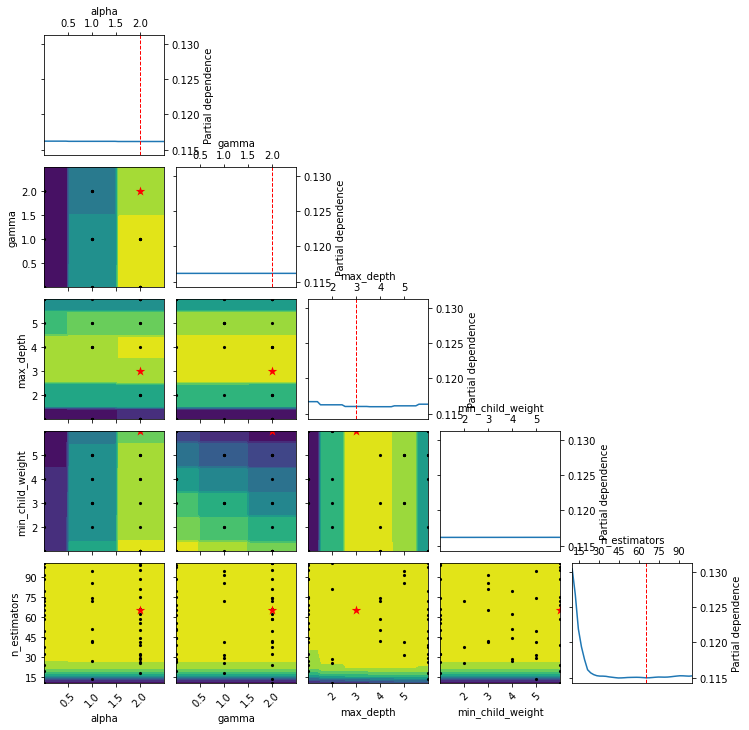

In [23]:
search1 = BayesSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1
                                                      , objective= 'binary:logistic'
                                                      , nthread=4, scale_pos_weight=1
                                                      , seed=27), 
                        search_spaces = {'n_estimators': (10, 100)
                        , 'max_depth': (1, 6)
                        , 'min_child_weight': (1, 6)
                        , 'alpha':(0, 2.5, 'uniform')
                        , 'gamma': (0, 2.5, 'uniform')}
                        , scoring='neg_brier_score',n_jobs=4, cv=5)
search1.fit(X_train,y_train)

print("val. score: %s" % search1.best_score_)
print("best params: %s" % str(search1.best_params_))

_ = plot_objective(search1.optimizer_results_[0],
                   dimensions=None,
                   n_minimum_search=int(1e8))
plt.show()

In [24]:
#xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42
#                              , max_depth = 1, min_child_weight = 6, n_estimators = 150
#                              , gamma = 0, reg_lambda = 1)
#xgb_model.fit(X_train, y_train)

y_pred_train = search1.predict_proba(X_train)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

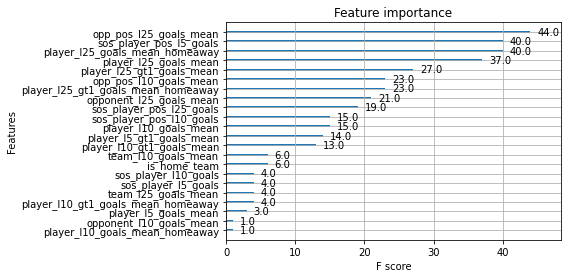

In [25]:
from xgboost import plot_importance
plot_importance(search1.best_estimator_)

In [26]:
X = dat[['is_home_team', 'player_l5_goals_mean', 'player_l5_gt1_goals_mean',
                     'player_l10_goals_mean', 'player_l10_gt1_goals_mean',
                     'player_l25_goals_mean', 'player_l25_gt1_goals_mean', 
                     'player_l10_goals_mean_homeaway', 'player_l10_gt1_goals_mean_homeaway',
                     'player_l25_goals_mean_homeaway', 'player_l25_gt1_goals_mean_homeaway',
                     'team_l10_goals_mean', 'team_l25_goals_mean',
                     'opponent_l10_goals_mean', 'opponent_l25_goals_mean',
                     'opp_pos_l10_goals_mean', 'opp_pos_l25_goals_mean',
                     'sos_player_l5_goals', 'sos_player_l10_goals', 'sos_player_l25_goals',
                     'sos_player_pos_l5_goals', 'sos_player_pos_l10_goals', 'sos_player_pos_l25_goals']]


y_pred = search1.predict_proba(X)

### xgb

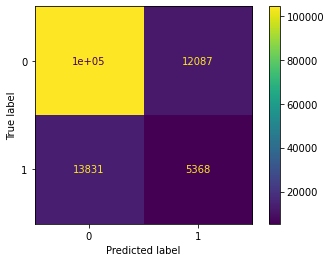

In [28]:
p = ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train[:, 1] >= 0.25))
p.plot()
plt.show()

In [29]:
dat['pred_goal'] = search1.predict_proba(X)[:, 1]
dat['odds'] = dat['pred_goal'].apply(convert_prob_to_american)

In [30]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Get today odds

In [31]:
import requests
import json
from bs4 import BeautifulSoup
import re 

# Create an URL object
url = 'https://www.rotowire.com/betting/nhl/player-props.php'
# Create object page
page = requests.get(url)

soup = BeautifulSoup(page.text)

In [32]:
results = re.findall(pattern = 'data: (.+])', string = soup.prettify())
odds = {}
for res in results:
    try:
        records = re.sub(pattern = '},{', repl= '}***{', string=res[1:-1]).split('***')
        records_df = pd.concat([pd.DataFrame(json.loads(rec), index = [1]) for rec in records])
        odds[records_df.columns[9]] = records_df
    
        print(records_df.columns[9])
        
    except:
        pass

draftkings_firstgoal
draftkings_anygoal
draftkings_anypoint
draftkings_ast
mgm_pppt
mgm_blk
draftkings_shot
draftkings_firstgoal
draftkings_firstgoal


In [33]:
import pickle
f = open('odds_{}.pkl'.format(date.today()), 'wb')
pickle.dump(odds, f)

In [34]:
today_games = dat.query('game_final == False')

In [40]:
today_games = today_games.merge(odds['draftkings_anygoal'][['name', 'draftkings_anygoal']]
                                , left_on = ['player_name'], right_on = ['name'], how='left')

In [42]:
for i, r in s.iterrows():
    print(r['away_team'])
    display(today_games.query('game_final == False & team == \"{}\"'.format(r['away_team']))[['game_date', 'player_name', 'shots', 'pred_goal'
                                                                                              , 'odds', 'draftkings_anygoal']].sort_values('odds'))

    print(r['home_team'])
    display(today_games.query('game_final == False & team == \"{}\"'.format(r['home_team']))[['game_date', 'player_name', 'shots', 'pred_goal'
                                                                                              , 'odds', 'draftkings_anygoal']].sort_values('odds'))

Buffalo Sabres


,game_date,player_name,shots,pred_goal,odds,draftkings_anygoal
5,2022-11-22 19:00:00,Tage Thompson,NaN,0.381586,162.063845,130
4,2022-11-22 19:00:00,Alex Tuch,NaN,0.310252,222.318651,190
10,2022-11-22 19:00:00,Victor Olofsson,NaN,0.294415,239.656886,240
8,2022-11-22 19:00:00,Jeff Skinner,NaN,0.277851,259.904491,225
21,2022-11-22 19:00:00,Rasmus Dahlin,NaN,0.244682,308.693038,330
14,2022-11-22 19:00:00,Casey Mittelstadt,NaN,0.234975,325.576685,330
3,2022-11-22 19:00:00,Kyle Okposo,NaN,0.218550,357.560582,330
12,2022-11-22 19:00:00,Rasmus Asplund,NaN,0.157078,536.628149,550
16,2022-11-22 19:00:00,Dylan Cozens,NaN,0.151744,559.004863,320
9,2022-11-22 19:00:00,Zemgus Girgensons,NaN,0.140827,610.092907,475


Montréal Canadiens


,game_date,player_name,shots,pred_goal,odds,draftkings_anygoal
29,2022-11-22 19:00:00,Cole Caufield,NaN,0.424048,135.822257,140
47,2022-11-22 19:00:00,Nick Suzuki,NaN,0.353558,182.838927,140
32,2022-11-22 19:00:00,Mike Hoffman,NaN,0.306038,226.756625,290
28,2022-11-22 19:00:00,Josh Anderson,NaN,0.250144,299.769630,265
48,2022-11-22 19:00:00,Kirby Dach,NaN,0.205644,386.277863,265
35,2022-11-22 19:00:00,Juraj Slafkovsky,NaN,0.199371,401.578148,330
25,2022-11-22 19:00:00,Evgenii Dadonov,NaN,0.199178,402.063380,390
45,2022-11-22 19:00:00,Christian Dvorak,NaN,0.184204,442.876209,330
26,2022-11-22 19:00:00,Brendan Gallagher,NaN,0.156158,540.376014,265
46,2022-11-22 19:00:00,Jake Evans,NaN,0.152945,553.828483,500


New York Rangers


,game_date,player_name,shots,pred_goal,odds,draftkings_anygoal
55,2022-11-22 22:30:00,Chris Kreider,NaN,0.314475,217.990030,150
61,2022-11-22 22:30:00,Mika Zibanejad,NaN,0.314451,218.014291,125
60,2022-11-22 22:30:00,Vincent Trocheck,NaN,0.246065,306.396108,280
58,2022-11-22 22:30:00,Artemi Panarin,NaN,0.227023,340.483039,250
52,2022-11-22 22:30:00,Julien Gauthier,NaN,0.197170,407.176844,500
66,2022-11-22 22:30:00,Adam Fox,NaN,0.196577,408.706749,450
64,2022-11-22 22:30:00,Filip Chytil,NaN,0.177987,461.839980,320
54,2022-11-22 22:30:00,Kaapo Kakko,NaN,0.175563,469.594576,300
62,2022-11-22 22:30:00,Barclay Goodrow,NaN,0.165230,505.215366,400
59,2022-11-22 22:30:00,Alexis Lafrenière,NaN,0.143178,598.429065,NaN


Los Angeles Kings


,game_date,player_name,shots,pred_goal,odds,draftkings_anygoal
94,2022-11-22 22:30:00,Gabriel Vilardi,NaN,0.285722,249.990055,205
87,2022-11-22 22:30:00,Kevin Fiala,NaN,0.273235,265.984934,205
80,2022-11-22 22:30:00,Phillip Danault,NaN,0.268802,272.021142,285
89,2022-11-22 22:30:00,Trevor Moore,NaN,0.261638,282.206932,285
91,2022-11-22 22:30:00,Adrian Kempe,NaN,0.247971,303.272724,150
95,2022-11-22 22:30:00,Arthur Kaliyev,NaN,0.201026,397.447188,380
90,2022-11-22 22:30:00,Alex Iafallo,NaN,0.182338,448.433066,NaN
84,2022-11-22 22:30:00,Blake Lizotte,NaN,0.165974,502.505229,600
79,2022-11-22 22:30:00,Anze Kopitar,NaN,0.142917,599.709049,270
92,2022-11-22 22:30:00,Viktor Arvidsson,NaN,0.132470,654.890550,255


In [ ]:
from plotnine import *
ggplot(aes(x = 'pred_3sog', y = 'shots')
       , data = dat[(dat['game_date'] >= dt.datetime.now() - dt.timedelta(days = 7)) & (dat['index'] != 1)]) +\
geom_point(alpha = 0.3) + geom_hline(aes(yintercept = 2.5), linetype = 'dashed')

In [ ]:
from plotnine import *
ggplot(aes(x = 'pred_3sog', y = 'shots')
       , data = dat[(dat['game_date'] >= dt.datetime.now() - dt.timedelta(days = 7)) & (dat['index'] != 1)]) +\
geom_point(alpha = 0.3) + geom_hline(aes(yintercept = 2.5), linetype = 'dashed')

In [ ]:
dat[(dat['game_date'] > dt.datetime.now() - dt.timedelta(days = 2)) & (dat['index'] != 1)][['game_date', 'player_name', 'shots', 'pred_3sog', 'odds']].sort_values('odds').head(150)

### SOG

In [ ]:
def format_sog(team):
    cor_dat = pd.read_sql("""SELECT b.* FROM nhl_player_boxscore b
     INNER JOIN nhl_schedule s ON b.game_pk = s.game_pk
     WHERE s.game_date >= '2021-06-01' AND b.team = \'{}\';""".format(team), engine)
    
    cor_dat['trimmed_sog'] = np.minimum(cor_dat['shots'], 6)

    players = cor_dat.groupby('player_name')['trimmed_sog'].sum().sort_values().tail(8).reset_index()['player_name']
    
    lvk = pd.pivot_table(cor_dat[cor_dat['player_name'].isin(players)], index = ['game_pk'], columns = 'player_name', values = ['trimmed_sog'])
    lvk.columns = [' '.join(col).strip() for col in lvk.columns.values]
    print(team)
#    display(lvk.mask(~lvk.isna(), lvk >= 2).mean().apply(convert_prob_to_american).to_frame(name = 'fair_odds').style.background_gradient(cmap = cm))
#    display(lvk.mask(~lvk.isna(), lvk >= 3).mean().apply(convert_prob_to_american).to_frame(name = 'fair_odds').style.background_gradient(cmap = cm))
#    display(lvk.mask(~lvk.isna(), lvk >= 4).mean().apply(convert_prob_to_american).to_frame(name = 'fair_odds').style.background_gradient(cmap = cm))

    corr = lvk.corr(min_periods = 12)
    display(corr.style.background_gradient(cmap = cm))


In [ ]:
import numpy as np
for i in range(s.shape[0]):
    cm = sns.light_palette("blue", as_cmap=True, reverse = True)

    team_one = s.loc[i]['away_team']
    team_two = s.loc[i]['home_team']

    format_sog(team_one)
    
    format_sog(team_two)


In [ ]:
dat = pd.read_sql("""SELECT b.*, s.game_date FROM nhl_player_boxscore b
     INNER JOIN nhl_schedule s ON b.game_pk = s.game_pk
     WHERE s.game_date >= '2021-06-01' AND b.team = \'{}\';""".format('Vegas Golden Knights'), engine)